## Data analysis
--- 
`NEW CONTINUING` script from [data_curation_cont](../notebooks/data_curation_cont.ipynb) script. 

Data processing pipeline: 
- [`data_curation.ipynb`](../notebooks/data_curation.ipynb)
- [`data_curation_cont.ipynb`](../notebooks/data_curation_cont.ipynb)
-  `data_analysis.ipynb` << You are here.

### Table of contents
> [Overview](#overview)
>
> [Morpheme counting](#morpheme-counting)
>
> [Visualizing frequency counts](#visualizing-frequency-counts)
>
> [Ranking order comparison](#morpheme-ranking-order-comparison)
>
> [Visualizing ranking order](#visualizing-ranking-order)
>
> [Ranked Biased Overlap](#ranked-biased-overlap-rbo)
>
>[Saving data](#saving-data)

In [1]:
# loading required libraries
import nltk, pickle, pprint, csv, re, pylangacq, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pretty printing for readability
cp = pprint.PrettyPrinter(compact=True, sort_dicts=True)

# loading data from last notebook
Lcorpus = pickle.load(open("../data/Lcorpus_cont.pkl", 'rb'))
Ncorpus = pickle.load(open("../data/Ncorpus_cont.pkl", 'rb'))

___

### Overview
According to R. Brown (1973), the starting point of acquisition order research, the order of L1 acquisition of English morphemes is as follows: 

| Rank        | Morpheme    |
| ----------- | ----------- |
| 1   | Present progressive (*-ing*)    |
| 2/3   | *in, on*       |
| 4   | Plural (*-s*)  |
| 5   | Past irregular      |
| 6   | Possessive (*-'s*)   |
| 7  | Uncontractible copula (*is, am, are*)   |
| 8  | Articles (*a, the*)   |
| 9   | Past regular (*-ed*)      |
| 10   | Third person singular (*-s*)     |
| 11   | Third person irregular     |
| 12   | Uncontractible auxiliary (*is, am, are*)  |
| 13  | Contractible copula  |
| 14  | Contractible auxiliary   |

This project will not analyze all of these, but I will attempt to cover most of them.

To begin the analysis, I'll extract and count instances of particular morphemes from each text. First, I'll test this out on a single row using the present progressive (verb suffix *-ing*). The MOR annotation scheme for the TalkBank corpora can be found [here](https://talkbank.org/manuals/MOR.html#_Toc65933281).

In [2]:
Ncorpus.head(1)

,Filename,Participant,Age,Tokens,POS,Morphemes
0,03\03a.cha,11312/c-00020713-1,3;01,"[., when, he's, sleeping, ,, ., and, his, frog...","[None, conj, pro:sub, aux, part, cm, ., coord,...","[None, when, he, be&3S, sleep-PRESP, cm, , and..."


In [3]:
# -PRESP is the TalkBank MOR annotation for a verb in the present progressive
pattern = r'\w*-PRESP\b'
# sample row
presp_test = Ncorpus.Morphemes[0]
# find all present progressive morphemes
presps = re.findall(pattern, ' '.join(str(x) for x in presp_test))
print(presps, '\ncount:', len(presps))

['sleep-PRESP', 'get-PRESP', 'stand-PRESP', 'run-PRESP'] 
count: 4


The first participant in our data frame, age 3 years and 1 month, used the present progressive 4 times: 'sleeping', 'getting', 'standing', and 'running'. Let's take a closer look. 

Now to define a function and get this information for the rest of the data.

In [4]:
def get_presp(x):
    pattern = r'\w*-PRESP\b'
    presps = re.findall(pattern, ' '.join(str(y) for y in x))
    return presps

In [5]:
# native speaker corpus 
Ncorpus['PresP_Count'] = Ncorpus.Morphemes.apply(get_presp).str.len()
Ncorpus.head()

,Filename,Participant,Age,Tokens,POS,Morphemes,PresP_Count
0,03\03a.cha,11312/c-00020713-1,3;01,"[., when, he's, sleeping, ,, ., and, his, frog...","[None, conj, pro:sub, aux, part, cm, ., coord,...","[None, when, he, be&3S, sleep-PRESP, cm, , and...",4
1,03\03b.cha,11312/c-00020714-1,3;04,"[they're, looking, at, it, ., and, there's, a,...","[pro:sub, aux, part, prep, pro:per, ., coord, ...","[they, be&PRES, look-PRESP, at, it, , and, the...",6
2,03\03c.cha,11312/c-00020715-1,3;04,"[there's, a, frog, in, there, ., he's, in, the...","[pro:exist, cop, det:art, n, prep, adv, ., pro...","[there, be&3S, a, frog, in, there, , he, be&3S...",8
3,03\03d.cha,11312/c-00020716-1,3;05,"[a, frog, a, person, ., a, person, ., a, boot,...","[det:art, n, det:art, n, ., det:art, n, ., det...","[a, frog, a, person, , a, person, , a, boot, ,...",23
4,03\03e.cha,11312/c-00020717-1,3;08,"[., there's, a, dog, ., and, there's, a, frog,...","[None, pro:exist, cop, det:art, n, ., coord, p...","[None, there, be&3S, a, dog, , and, there, be&...",3


In [6]:
# learner corpus
Lcorpus['PresP_Count'] = Lcorpus.Morphemes.apply(get_presp).str.len()
Lcorpus.head()

,Filename,Participant,Anon_ID,L1,Age,Education,Years_Learn,Years_Env,Tokens,POS,Morphemes,PresP_Count
0,Vercellotti\1060_3G1.cha,1060,fm5,Arabic,19.0,level4,more than 5 years,less than 1 year,"[my, topic, is, describe, your, favorite, meal...","[det:poss, n, cop, v, det:poss, adj, n, prep, ...","[my, topic, be&3S, describe, your, favorite, m...",5
1,Vercellotti\1060_3G2.cha,1060,fm5,Arabic,19.0,level4,more than 5 years,less than 1 year,"[the, topic, is, transportation, ., in, this, ...","[det:art, n, cop, n, ., prep, det:dem, n, qn, ...","[the, topic, be&3S, transport&dv-ATION, , in, ...",0
2,Vercellotti\1060_3G3.cha,1060,fm5,Arabic,19.0,level4,more than 5 years,less than 1 year,"[the, topic, is, someone, I, admire, ., I'll, ...","[det:art, n, cop, pro:indef, pro:sub, v, ., pr...","[the, topic, be&3S, someone, I, admire, , I, w...",0
3,Vercellotti\1060_4P1.cha,1060,fm5,Arabic,19.0,level4,more than 5 years,less than 1 year,"[the, topic, is, talking, about, a, problem, i...","[det:art, n, aux, part, prep, det:art, n, prep...","[the, topic, be&3S, talk-PRESP, about, a, prob...",4
4,Vercellotti\1060_4P2.cha,1060,fm5,Arabic,19.0,level4,more than 5 years,less than 1 year,"[the, topic, is, talk, about, something, I, re...","[det:art, n, cop, v, adv, pro:indef, pro:sub, ...","[the, topic, be&3S, talk, about, something, I,...",3


### Morpheme counting
Doing the same for other important morphemes.

In [7]:
# in
def get_in(x):
    pattern = r'\bin\b'
    ins = re.findall(pattern, ' '.join(str(y) for y in x))
    return ins

# adding data to the data frames
Ncorpus['In_Count'] = Ncorpus.Morphemes.apply(get_in).str.len()
Lcorpus['In_Count'] = Lcorpus.Morphemes.apply(get_in).str.len()

In [8]:
# on
def get_on(x):
    pattern = r'\bon\b'
    ons = re.findall(pattern, ' '.join(str(y) for y in x))
    return ons

# adding data to the data frames
Ncorpus['On_Count'] = Ncorpus.Morphemes.apply(get_on).str.len()
Lcorpus['On_Count'] = Lcorpus.Morphemes.apply(get_on).str.len()

In [9]:
# past irregular
def get_pastirr(x):
    pattern = r'\w*&PAST\b'
    pastirr = re.findall(pattern, ' '.join(str(y) for y in x))
    return pastirr
# adding data to the data frames
Ncorpus['PastIrr_Count'] = Ncorpus.Morphemes.apply(get_pastirr).str.len()
Lcorpus['PastIrr_Count'] = Lcorpus.Morphemes.apply(get_pastirr).str.len()

In [10]:
# possessives
def get_poss(x):
    pattern = r'\w*-POSS\b'
    poss = re.findall(pattern, ' '.join(str(y) for y in x))
    return poss

# adding data to the data frames
Ncorpus['Poss_Count'] = Ncorpus.Morphemes.apply(get_poss).str.len()
Lcorpus['Poss_Count'] = Lcorpus.Morphemes.apply(get_poss).str.len()

In [11]:
# copula
def get_cop(x):
    pattern = r'cop'
    cops = re.findall(pattern, ' '.join(str(y) for y in x))
    return cops

# adding data to the data frames
Ncorpus['Cop_Count'] = Ncorpus.POS.apply(get_cop).str.len()
Lcorpus['Cop_Count'] = Lcorpus.POS.apply(get_cop).str.len()

In [12]:
# articles
def get_art(x):
    pattern = r'det:art'
    arts = re.findall(pattern, ' '.join(str(y) for y in x))
    return arts

# adding data to the data frames
Ncorpus['Art_Count'] = Ncorpus.POS.apply(get_art).str.len()
Lcorpus['Art_Count'] = Lcorpus.POS.apply(get_art).str.len()

In [13]:
# past regular
def get_pastreg(x):
    pattern = r'\w*-PAST\b'
    pastreg = re.findall(pattern, ' '.join(str(y) for y in x))
    return pastreg

# adding data to the data frames
Ncorpus['PastReg_Count'] = Ncorpus.Morphemes.apply(get_pastreg).str.len()
Lcorpus['PastReg_Count'] = Lcorpus.Morphemes.apply(get_pastreg).str.len()

In [14]:
# third person singular
def get_tps(x):
    pattern = r'\w*-3S\b'
    tps = re.findall(pattern, ' '.join(str(y) for y in x))
    return tps

# adding data to the data frames
Ncorpus['3PS_Count'] = Ncorpus.Morphemes.apply(get_tps).str.len()
Lcorpus['3PS_Count'] = Lcorpus.Morphemes.apply(get_tps).str.len()

In [15]:
# third person irregular
def get_tpirr(x):
    pattern = r'\w*&3S\b' 
    tpirr = re.findall(pattern, ' '.join(str(y) for y in x))
    return tpirr

# adding data to the data frames
Ncorpus['3PIrr_Count'] = Ncorpus.Morphemes.apply(get_tpirr).str.len()
Lcorpus['3PIrr_Count'] = Lcorpus.Morphemes.apply(get_tpirr).str.len()

In [16]:
# auxiliary
def get_aux(x):
    pattern = r'aux'
    aux = re.findall(pattern, ' '.join(str(y) for y in x))
    return aux

# adding data to the data frames
Ncorpus['Aux_Count'] = Ncorpus.POS.apply(get_aux).str.len()
Lcorpus['Aux_Count'] = Lcorpus.POS.apply(get_aux).str.len()

Morpheme counting completed. Morpheme counts alone are also not necessarily informative. These values need to be normalized so that they are not affected by other factors such as length of the text.

In [17]:
# token counts
Ncorpus['Token_Count'] = Ncorpus['Tokens'].str.len()
Lcorpus['Token_Count'] = Lcorpus['Tokens'].str.len()

In [18]:
# normalizing counts
Lcorpus[['PresP_Count', 'In_Count', 'On_Count', 'PastIrr_Count', 
        'Poss_Count', 'Cop_Count', 'Art_Count', 'PastReg_Count', 
        '3PS_Count', '3PIrr_Count', 'Aux_Count']] = Lcorpus[['PresP_Count', 'In_Count', 'On_Count', 'PastIrr_Count', 
        'Poss_Count', 'Cop_Count', 'Art_Count', 'PastReg_Count', 
        '3PS_Count', '3PIrr_Count', 'Aux_Count']].div(Lcorpus.Token_Count, axis=0)
Ncorpus[['PresP_Count', 'In_Count', 'On_Count', 'PastIrr_Count', 
        'Poss_Count', 'Cop_Count', 'Art_Count', 'PastReg_Count', 
        '3PS_Count', '3PIrr_Count', 'Aux_Count']] = Ncorpus[['PresP_Count', 'In_Count', 'On_Count', 'PastIrr_Count', 
        'Poss_Count', 'Cop_Count', 'Art_Count', 'PastReg_Count', 
        '3PS_Count', '3PIrr_Count', 'Aux_Count']].div(Ncorpus.Token_Count, axis=0)

In [19]:
# L1 corpus
Ncorpus['Age']= Ncorpus['Age'].str.replace(';','.').astype(float)
Ncorpus['Age']= pd.Categorical(Ncorpus['Age'], ordered=True)
Ncorp_counts = Ncorpus[['Age', 'PresP_Count', 'In_Count', 'On_Count', 'PastIrr_Count', 
        'Poss_Count', 'Cop_Count', 'Art_Count', 'PastReg_Count', 
        '3PS_Count', '3PIrr_Count', 'Aux_Count']].groupby("Age").mean()
Ncorp_counts

,PresP_Count,In_Count,On_Count,PastIrr_Count,Poss_Count,Cop_Count,Art_Count,PastReg_Count,3PS_Count,3PIrr_Count,Aux_Count
Age,,,,,,,,,,,
3.01,0.050633,0.000000,0.025316,0.050633,0.000000,0.012658,0.063291,0.012658,0.000000,0.063291,0.037975
3.04,0.070827,0.031765,0.000000,0.007812,0.007812,0.042571,0.075646,0.007812,0.000000,0.061190,0.026432
3.05,0.064789,0.014085,0.016901,0.033803,0.000000,0.033803,0.118310,0.000000,0.005634,0.030986,0.028169
3.08,0.029412,0.039216,0.000000,0.039216,0.000000,0.058824,0.088235,0.009804,0.000000,0.098039,0.039216
3.09,0.041602,0.013056,0.006287,0.023674,0.002174,0.018576,0.102091,0.023606,0.002404,0.045664,0.039330
3.1,0.052163,0.022115,0.000000,0.017308,0.000000,0.018990,0.132692,0.012740,0.006250,0.066587,0.060096
3.11,0.042180,0.025553,0.019456,0.069399,0.003049,0.011252,0.104319,0.018293,0.000000,0.010309,0.008203
4.04,0.008811,0.013216,0.008811,0.070485,0.000000,0.022026,0.154185,0.048458,0.000000,0.004405,0.017621
4.06,0.023090,0.025822,0.002232,0.020589,0.000000,0.014893,0.084395,0.026786,0.016393,0.031287,0.028054


I decided to consolidate the data collected from the subjects beyond 9 years of age into one group. Motivating this decision was the need to have somewhat of a starting and ending point in the acquisition process demonstrated through the progression of the data. In the L2 corpus, the final category of years spent learning English is 5 or more years of learning. So to parallel this end point, I'm combining the means of subjects 9 and older. I believe it is unlikely that the learners' use of the functors acquired very early on in language acquisition differs significantly beyond the age of 9. 

In [20]:
# consolidating data for ages 9 and above
row_index= [9.01,9.03,9.06,9.08,9.09,9.1,9.11,20.0]
age9up= Ncorp_counts[Ncorp_counts.columns].iloc[row_index].mean(axis=0)
age9up

PresP_Count      0.044448
In_Count         0.015044
On_Count         0.018268
PastIrr_Count    0.042488
Poss_Count       0.002950
Cop_Count        0.020448
Art_Count        0.088690
PastReg_Count    0.023324
3PS_Count        0.016504
3PIrr_Count      0.035758
Aux_Count        0.033045
dtype: float64

In [21]:
Ncorp_counts= Ncorp_counts.iloc[:22]
Ncorp_counts.loc['9+']= age9up.tolist()
Ncorp_counts

C:\Users\dinoc\AppData\Local\Temp\ipykernel_23212\4051360380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ncorp_counts.loc['9+']= age9up.tolist()


,PresP_Count,In_Count,On_Count,PastIrr_Count,Poss_Count,Cop_Count,Art_Count,PastReg_Count,3PS_Count,3PIrr_Count,Aux_Count
Age,,,,,,,,,,,
3.01,0.050633,0.000000,0.025316,0.050633,0.000000,0.012658,0.063291,0.012658,0.000000,0.063291,0.037975
3.04,0.070827,0.031765,0.000000,0.007812,0.007812,0.042571,0.075646,0.007812,0.000000,0.061190,0.026432
3.05,0.064789,0.014085,0.016901,0.033803,0.000000,0.033803,0.118310,0.000000,0.005634,0.030986,0.028169
3.08,0.029412,0.039216,0.000000,0.039216,0.000000,0.058824,0.088235,0.009804,0.000000,0.098039,0.039216
3.09,0.041602,0.013056,0.006287,0.023674,0.002174,0.018576,0.102091,0.023606,0.002404,0.045664,0.039330
3.1,0.052163,0.022115,0.000000,0.017308,0.000000,0.018990,0.132692,0.012740,0.006250,0.066587,0.060096
3.11,0.042180,0.025553,0.019456,0.069399,0.003049,0.011252,0.104319,0.018293,0.000000,0.010309,0.008203
4.04,0.008811,0.013216,0.008811,0.070485,0.000000,0.022026,0.154185,0.048458,0.000000,0.004405,0.017621
4.06,0.023090,0.025822,0.002232,0.020589,0.000000,0.014893,0.084395,0.026786,0.016393,0.031287,0.028054


In [22]:
# L2 corpus
Lcorpus['Years_Learn'] = pd.Categorical(Lcorpus['Years_Learn'],
                                        ['less than 1 year', '1-2 years', '3-5 years',
                                         'more than 5 years'])
Lcorp_counts = Lcorpus[['Years_Learn', 'PresP_Count', 'In_Count', 'On_Count', 'PastIrr_Count', 
        'Poss_Count', 'Cop_Count', 'Art_Count', 'PastReg_Count', 
        '3PS_Count', '3PIrr_Count', 'Aux_Count']].groupby("Years_Learn").mean()
Lcorp_counts

,PresP_Count,In_Count,On_Count,PastIrr_Count,Poss_Count,Cop_Count,Art_Count,PastReg_Count,3PS_Count,3PIrr_Count,Aux_Count
Years_Learn,,,,,,,,,,,
less than 1 year,0.012039,0.021260,0.000878,0.027361,0.000226,0.041170,0.051258,0.009242,0.002192,0.028158,0.013034
1-2 years,0.011227,0.021712,0.003009,0.021357,0.000000,0.032253,0.048732,0.006873,0.002880,0.025825,0.013120
3-5 years,0.012935,0.022241,0.000526,0.017896,0.000586,0.041438,0.055516,0.005897,0.002357,0.033155,0.011308
more than 5 years,0.012690,0.023746,0.003156,0.015538,0.000336,0.036640,0.061591,0.005599,0.004418,0.029697,0.012471


These data frames are not the easiest to parse. From a brief glance at the native speaker corpus, it appears that there may be some patterns in the occurence of partiuclar morphemes that seem to increase with age through the proposed acquisition order. However, the learner corpus doesn't appear to demonstrate any discernable pattern at this stage. Generating some visualizations should help make sense of this. 

However, it is critical to address one caveat: these count frequencies represent *any* occurence of a given morpheme, including incorrect or erroneous suppliances. Because it also includes incorrectly supplied morphemes, it is not as robust as an analysis of suppliance in obligatory context.

### Visualizing frequency counts

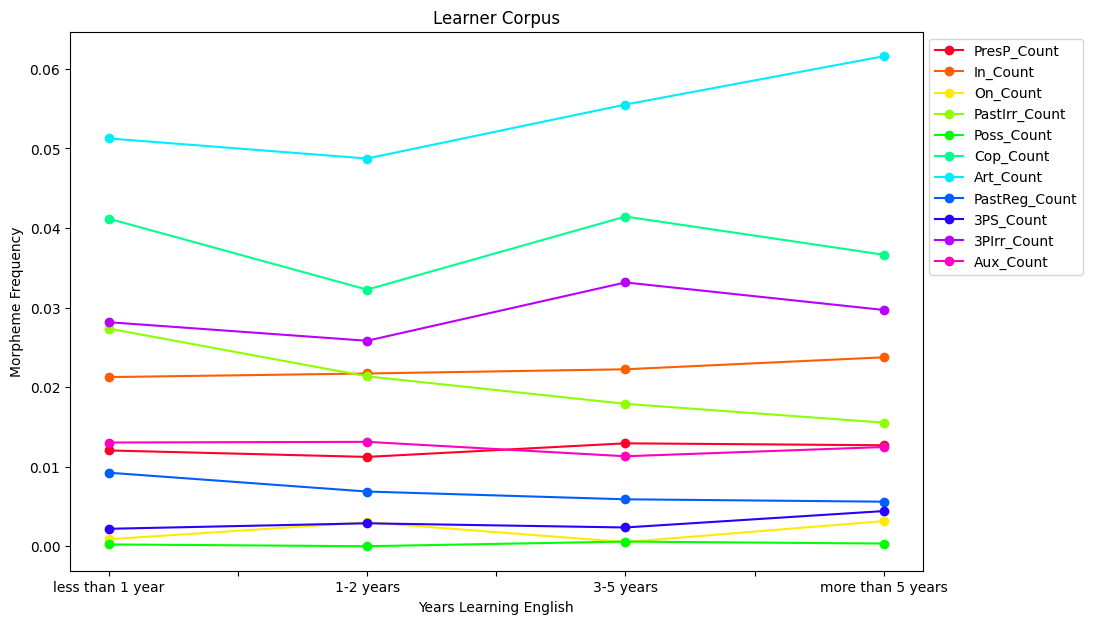

In [23]:
ax= Lcorp_counts.plot(use_index=True, figsize= (11,7), colormap= 'gist_rainbow', marker='o',
                  xlabel= 'Years Learning English', ylabel= 'Morpheme Frequency', title= 'Learner Corpus')
ax.legend(bbox_to_anchor=(1, 1))
plt.savefig('../data_samples/visuals/Lcorp_linegraph.png')
plt.show()

In these graphs, the legend is ordered according to the proposed natural order of acquisition of morphemes. As such, we would expect to see functors at the top of the list, such as PresP, In, On, PastIrr, and so on, with higher frequencies earlier on, at the start of the x-axis. Functors acquired later, such as Aux_Count, 3PIrr, and 3PS, should demonstrate the opposite tendency, starting off with a 0 or near 0 frequency and emerging farther along the x-axis as learners progress in the time spent learning English. 

The data in this case does not appear to follow such a predicted pattern. However, there are many other interesting patterns that are presented by this graph, to be expanded upon soon.

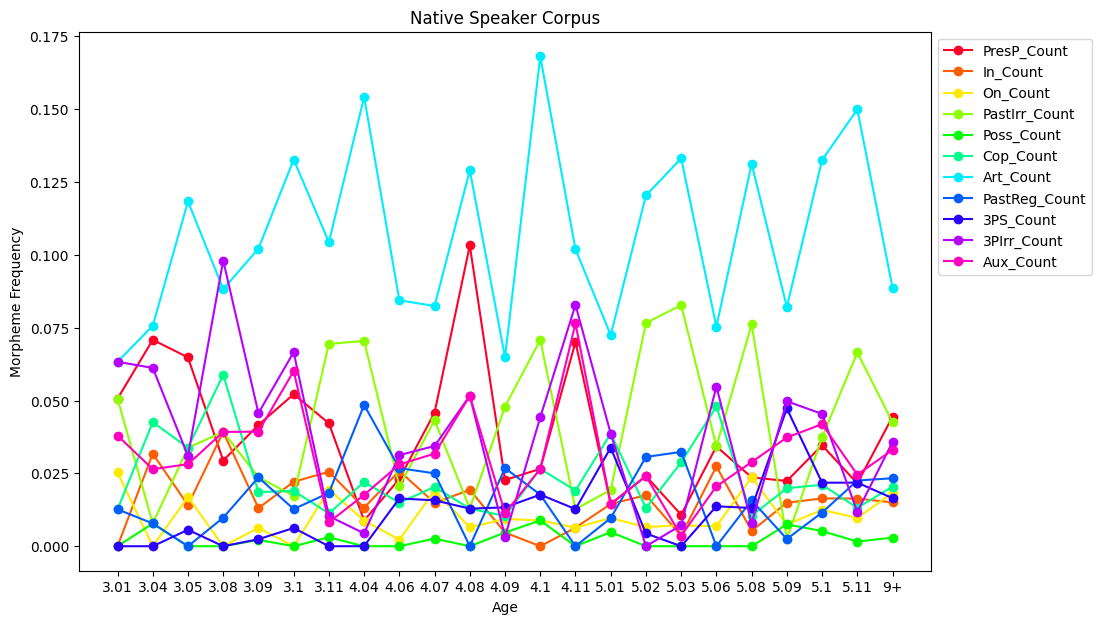

In [24]:
ax= Ncorp_counts.plot(use_index=True, figsize= (11,7), colormap= 'gist_rainbow', marker='o',
                  xlabel= 'Age', ylabel= 'Morpheme Frequency', title= 'Native Speaker Corpus')
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xticks(range(len(Ncorp_counts)))
ax.set_xticklabels(Ncorp_counts.index)
plt.savefig('../data_samples/visuals/Ncorp_linegraph.png')
plt.show()

The native speaker data also does not appear to follow a clear, predictable pattern of development. More peaks and valleys of frequency can be observed but this does not necessarily indicate a difference in the pattern or nature of acquisition between L1 and L2 learners. This can be attributed to the differences in the x-axes, which are not to scale, and with the L1 corpus having significantly more specific time points, detailed by the subjects age in year and months rather than general categories of the number of years spent learning English. 

### Morpheme ranking order comparison
In order to gain additional insights, I will generate a dataframe comparing the orders of frequency ranking at the start and end of the timespan detailed by the corpora to compare the differences within and between the L1 and L2 groups. 

In [25]:
Nstart_rank= Ncorp_counts[Ncorp_counts.columns].iloc[0]
Nfinal_rank= Ncorp_counts[Ncorp_counts.columns].iloc[-1]
Lstart_rank= Lcorp_counts[Ncorp_counts.columns].iloc[0]
Lfinal_rank= Lcorp_counts[Ncorp_counts.columns].iloc[-1]

Pandas `.rank()`, used below to calculate the ranking order, compute numerical data ranks (1 through n) along axis. By default, equal values are assigned a rank that is the average of the ranks of those values.

In [26]:
Nstart_rank= Nstart_rank.to_frame()
Nstart_rank.reset_index(inplace=True)
Nstart_rank.index= np.arange(1, len(Nstart_rank) + 1)
Nstart_rank.rename(columns={'index':'Morpheme', 3.01:'Nstart_Freq'}, inplace=True)
Nstart_rank['Nstart_Rank'] = Nstart_rank['Nstart_Freq'].rank()

In [27]:
Lstart_rank= Lstart_rank.to_frame()
Lstart_rank.reset_index(inplace=True)
Lstart_rank.index= np.arange(1, len(Lstart_rank) + 1)
Lstart_rank.rename(columns={'index':'Morpheme', 'less than 1 year':'Lstart_Freq'}, inplace=True)
Lstart_rank['Lstart_Rank'] = Lstart_rank['Lstart_Freq'].rank()

In [28]:
Nfinal_rank= Nfinal_rank.to_frame()
Nfinal_rank.reset_index(inplace=True)
Nfinal_rank.index= np.arange(1, len(Nfinal_rank) + 1)
Nfinal_rank.rename(columns={'index':'Morpheme', '9+':'Nfinal_Freq'}, inplace=True)
Nfinal_rank['Nfinal_Rank'] = Nfinal_rank['Nfinal_Freq'].rank()

In [29]:
Lfinal_rank= Lfinal_rank.to_frame()
Lfinal_rank.reset_index(inplace=True)
Lfinal_rank.index= np.arange(1, len(Lfinal_rank) + 1)
Lfinal_rank.rename(columns={'index':'Morpheme', 'more than 5 years':'Lfinal_Freq'}, inplace=True)
Lfinal_rank['Lfinal_Rank'] = Lfinal_rank['Lfinal_Freq'].rank()

In [30]:
# concatenating into a single dataframe
rank_comparison= pd.concat([Nstart_rank, Nfinal_rank, Lstart_rank, Lfinal_rank], axis=1)
rank_comparison= rank_comparison.T.drop_duplicates().T
rank_comparison.reset_index(drop=True, inplace= True)
rank_comparison

,Morpheme,Nstart_Freq,Nstart_Rank,Nfinal_Freq,Nfinal_Rank,Lstart_Freq,Lstart_Rank,Lfinal_Freq,Lfinal_Rank
0,PresP_Count,0.050633,8.5,0.044448,10.0,0.012039,5.0,0.01269,6.0
1,In_Count,0.0,2.0,0.015044,2.0,0.02126,7.0,0.023746,8.0
2,On_Count,0.025316,6.0,0.018268,4.0,0.000878,2.0,0.003156,2.0
3,PastIrr_Count,0.050633,8.5,0.042488,9.0,0.027361,8.0,0.015538,7.0
4,Poss_Count,0.0,2.0,0.00295,1.0,0.000226,1.0,0.000336,1.0
5,Cop_Count,0.012658,4.5,0.020448,5.0,0.04117,10.0,0.03664,10.0
6,Art_Count,0.063291,10.5,0.08869,11.0,0.051258,11.0,0.061591,11.0
7,PastReg_Count,0.012658,4.5,0.023324,6.0,0.009242,4.0,0.005599,4.0
8,3PS_Count,0.0,2.0,0.016504,3.0,0.002192,3.0,0.004418,3.0
9,3PIrr_Count,0.063291,10.5,0.035758,8.0,0.028158,9.0,0.029697,9.0


### Visualizing ranking order
There appear to be quite a few differences in the ranking order across the groups. Now to generate scatterplots to provide visualizations for additional interpretation.

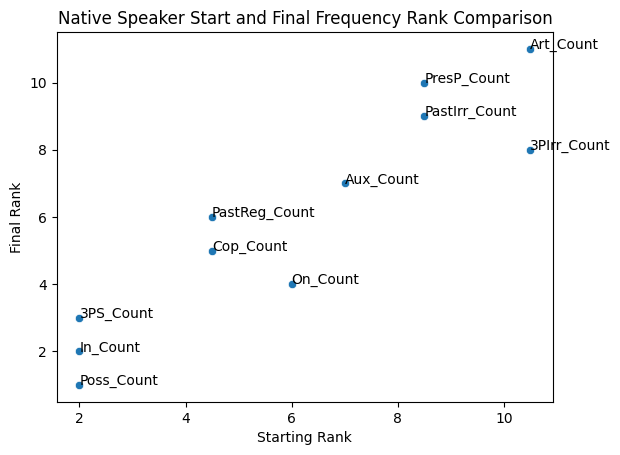

In [31]:
# native speaker starting frequency ranking vs final frequency ranking
sns.scatterplot(data= rank_comparison, x= rank_comparison.Nstart_Rank, y= rank_comparison.Nfinal_Rank)
for i in range(rank_comparison.shape[0]):
 plt.text(x= rank_comparison.Nstart_Rank[i],
 y= rank_comparison.Nfinal_Rank[i],
 s= rank_comparison.Morpheme[i])
plt.title('Native Speaker Start and Final Frequency Rank Comparison')
plt.xlabel('Starting Rank')
plt.ylabel('Final Rank')
plt.savefig('../data_samples/visuals/Nstart_final_rank.png')
plt.show()

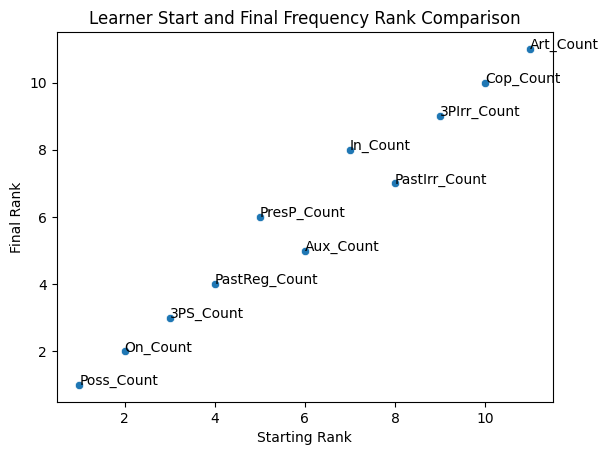

In [32]:
# learner starting frequency ranking vs final frequency ranking
sns.scatterplot(data= rank_comparison, x= rank_comparison.Lstart_Rank, y= rank_comparison.Lfinal_Rank)
for i in range(rank_comparison.shape[0]):
 plt.text(x= rank_comparison.Lstart_Rank[i],
 y= rank_comparison.Lfinal_Rank[i],
 s= rank_comparison.Morpheme[i])
plt.title('Learner Start and Final Frequency Rank Comparison')
plt.xlabel('Starting Rank')
plt.ylabel('Final Rank')
plt.savefig('../data_samples/visuals/Lstart_final_rank.png')
plt.show()

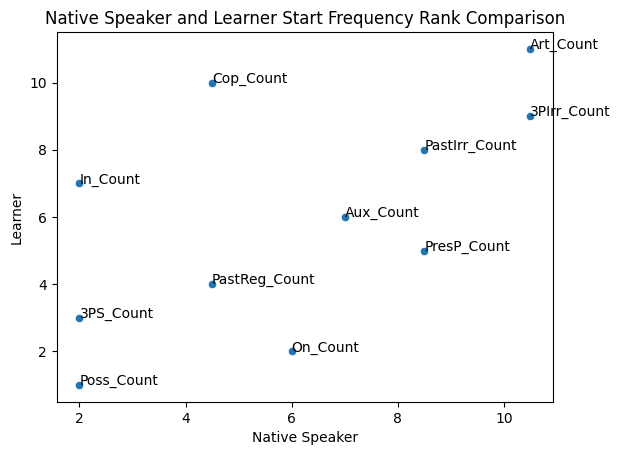

In [33]:
# native speaker starting frequency ranking vs learner starting frequency ranking
sns.scatterplot(data= rank_comparison, x= rank_comparison.Nstart_Rank, y= rank_comparison.Lstart_Rank)
for i in range(rank_comparison.shape[0]):
 plt.text(x= rank_comparison.Nstart_Rank[i],
 y= rank_comparison.Lstart_Rank[i],
 s= rank_comparison.Morpheme[i])
plt.title('Native Speaker and Learner Start Frequency Rank Comparison')
plt.xlabel('Native Speaker')
plt.ylabel('Learner')
plt.savefig('../data_samples/visuals/Nstart_lstart_rank.png')
plt.show()

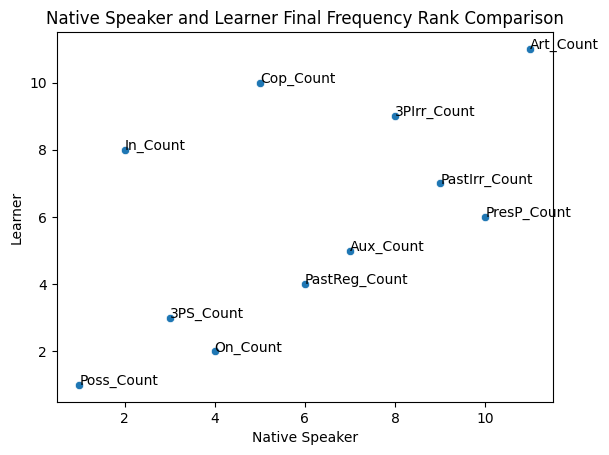

In [34]:
# native speaker final frequency ranking vs learner final frequency ranking
sns.scatterplot(data= rank_comparison, x= rank_comparison.Nfinal_Rank, y= rank_comparison.Lfinal_Rank)
for i in range(rank_comparison.shape[0]):
 plt.text(x= rank_comparison.Nfinal_Rank[i],
 y= rank_comparison.Lfinal_Rank[i],
 s= rank_comparison.Morpheme[i])
plt.title('Native Speaker and Learner Final Frequency Rank Comparison')
plt.xlabel('Native Speaker')
plt.ylabel('Learner')
plt.savefig('../data_samples/visuals/Nfinal_lfinal_rank.png')
plt.show()

### Ranked Biased Overlap (RBO)

I will implement a ranked list comparison to verify mathematically the extent to which order of freqency ranks are different. The method I will use is called Ranked Biased Overlap (RBO), proposed by Weber et al. (2010) and described [here](https://towardsdatascience.com/how-to-objectively-compare-two-ranked-lists-in-python-b3d74e236f6a), from which I borrowed the following RBO calculator function.

In [35]:
# RBO calculator function
def rbo(S,T, p= 0.9):
    """ Takes two lists S and T of any lengths and gives out the RBO Score
    Parameters
    ----------
    S, T : Lists (str, integers)
    p : Weight parameter, giving the influence of the first d
        elements on the final score. p<0<1. Default 0.9 give the top 10 
        elements 86% of the contribution in the final score.
    
    Returns
    -------
    Float of RBO score
    """
    
    # Fixed Terms
    k = max(len(S), len(T))
    x_k = len(set(S).intersection(set(T)))
    
    summation_term = 0

    # Loop for summation
    # k+1 for the loop to reach the last element (at k) in the bigger list    
    for d in range (1, k+1): 
            # Create sets from the lists
            set1 = set(S[:d]) if d < len(S) else set(S)
            set2 = set(T[:d]) if d < len(T) else set(T)
            
            # Intersection at depth d
            x_d = len(set1.intersection(set2))

            # Agreement at depth d
            a_d = x_d/d   
            
            # Summation
            summation_term = summation_term + math.pow(p, d) * a_d

    # Rank Biased Overlap - extrapolated
    rbo_ext = (x_k/k) * math.pow(p, k) + ((1-p)/p * summation_term)

    return rbo_ext

In [36]:
print('Native start rank vs native final rank:', 
rbo(rank_comparison['Nstart_Rank'], rank_comparison['Nfinal_Rank']))
print('Learner start rank vs learner final rank:',
rbo(rank_comparison['Lstart_Rank'], rank_comparison['Lfinal_Rank']))
print('Native start rank vs learner start rank:', 
rbo(rank_comparison['Nstart_Rank'], rank_comparison['Lstart_Rank']))
print('Native final rank vs learner final rank:', 
rbo(rank_comparison['Nfinal_Rank'], rank_comparison['Lfinal_Rank']))

Native start rank vs native final rank: 0.245146404592987
Learner start rank vs learner final rank: 0.6925836005742858
Native start rank vs learner start rank: 0.18551051945298697
Native final rank vs learner final rank: 0.5842608917528571


An RBO score indicates the percentage of similarity between the ranking of the order of frequency. Therefore, it seems that the ranking of the most frequent morphemes that native English speakers use at age 3 are 25% similar to the ranking of the most requent morphemes at ages 9+. Therefore, 75% dissimilar, meaning that the learners have certainly acquired additional morphemes and are using them to varying degrees. 

The learner start rank and learner final rank are much more similar to each other at about 69%. So, despite acquiring additional morphemes, it appears that they produce the morphemes at similar frequencies at the starting point of less than 1 year learning English to the final point of learning English for 5+ years.

The native start rank compared to the learner start rank is the smallest percentage, at 19%, meaning the order ranking of frequency at which the learners and native speakers use particular morphemes is quite dissimilar. This may be due to the scope or timelines of the respective corpora throughout stages of acquisition, or perhaps the influence of language instruction on the learners. 

Finally, it seems that the native final rank and learner final rank are much more similar than their starting rank. So, perhaps despite starting with a somewhat different arsenal of morphemes they are able to produce frequently, they follow some sort of similar developmental pattern towards later stages of acquisition.

### Saving data

In [37]:
Ncorp_counts.to_csv(r'../data_samples/Ncorp_counts.csv', header=True)
Lcorp_counts.to_csv(r'../data_samples/Lcorp_counts.csv', header=True)
rank_comparison.to_csv(r'../data_samples/rank_comparison.csv', header=True)